# Data Preparation

Downloading data and get helper functions

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2022-06-15 11:03:46--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-15 11:03:47 (74.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]

--2022-06-15 11:03:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 74.125.20.128, 108.177.98.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 

In [2]:
# Import series of helper function for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys

In [3]:
import zipfile

path = '101_food_classes_10_percent.zip'
zip_ref = zipfile.ZipFile(path,'r')
zip_ref.extractall()
zip_ref.close()

In [4]:
train_dir = '101_food_classes_10_percent/train'
validate_dir = '101_food_classes_10_percent/test'

In [5]:
import tensorflow as tf

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode='categorical',
                                                                 image_size=(224,224))

validate_data =tf.keras.preprocessing.image_dataset_from_directory(validate_dir,
                                                                   label_mode='categorical',
                                                                   image_size=(224,224),
                                                                   shuffle=False)



Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [6]:
# Create checkpoint callbacks

checkpoint_path = 'checkpoints_weight'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weighs_only=True,
                                                         save_best_only=True,
                                                         monitor='val_accuracy')

In [7]:
# Create data augmentation layer to incorporate it right into the model

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras

data_augmentation = keras.Sequential([
                                      preprocessing.RandomFlip('horizontal'),
                                      preprocessing.RandomRotation(0.2),
                                      preprocessing.RandomZoom(0.2),
                                      preprocessing.RandomHeight(0.2),
                                      preprocessing.RandomWidth(0.2),
                                      # preprocessing.Rescaling(1./255.)
], name='data_augmentation_layer')

## Model #0

In [8]:
# Create base model or backbone
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224,224,3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)

# Change into feature vector
x = layers.GlobalAveragePooling2D(name='global_average_pooling')(x)

outputs = layers.Dense(len(train_data.class_names),activation='softmax',name='output_layer')(x)

model_0 = tf.keras.Model(inputs,outputs)

model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_0.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                              

In [9]:
history_0 = model_0.fit(train_data,
                        validation_data=validate_data,
                        epochs=5,
                        validation_steps=int(0.15*len(validate_data)),
                        callbacks=[checkpoint_callback,create_tensorboard_callback('transfer_learning','model_0')])

Saving TensorBoard log files to: transfer_learning/model_0/20220615-110419
Epoch 1/5
237/237 [==============================] - 127s 463ms/step - loss: 3.4575 - accuracy: 0.2520 - val_loss: 2.7059 - val_accuracy: 0.3904
Epoch 2/5
237/237 [==============================] - 93s 390ms/step - loss: 2.3452 - accuracy: 0.4587 - val_loss: 2.2994 - val_accuracy: 0.4404
Epoch 3/5
237/237 [==============================] - 88s 370ms/step - loss: 1.9721 - accuracy: 0.5291 - val_loss: 2.1369 - val_accuracy: 0.4632
Epoch 4/5
237/237 [==============================] - 86s 360ms/step - loss: 1.7521 - accuracy: 0.5764 - val_loss: 2.0515 - val_accuracy: 0.4735
Epoch 5/5
237/237 [==============================] - 85s 356ms/step - loss: 1.5947 - accuracy: 0.6025 - val_loss: 2.0082 - val_accuracy: 0.4793


In [10]:
evaluate_0 = model_0.evaluate(validate_data)

790/790 [==============================] - 57s 72ms/step - loss: 1.7244 - accuracy: 0.5480


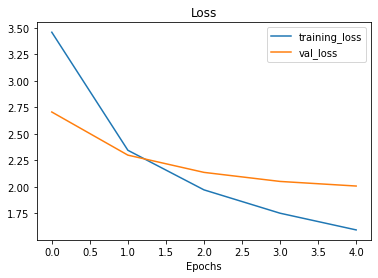

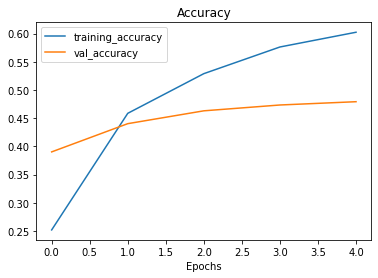

In [11]:
plot_loss_curves(history_0)

## Model #1
Fine tune of model #0

In [12]:
for layer in model_0.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f5fc98ca290> True
<keras.engine.sequential.Sequential object at 0x7f5fc98a04d0> True
<keras.engine.functional.Functional object at 0x7f5fc01b1810> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f5fc98ca1d0> True
<keras.layers.core.dense.Dense object at 0x7f5fc01b7d10> True


### Fine-Tuning last 5 layers

In [13]:
base_model.trainable=True

for layer in base_model.layers[:-5]:
  layer.trainable = False

model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

for i, layer in enumerate(model_0.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [14]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 910,821
Non-trainab

In [15]:
history_1 = model_0.fit(train_data,
            validation_data=validate_data,
            epochs=10,
            validation_steps=int(0.15*len(validate_data)),
            initial_epoch=history_0.epoch[-1],
            callbacks=[checkpoint_callback,create_tensorboard_callback('transfer_learning','model_1')])

Saving TensorBoard log files to: transfer_learning/model_1/20220615-111412
Epoch 5/10
237/237 [==============================] - 92s 357ms/step - loss: 1.3708 - accuracy: 0.6495 - val_loss: 1.9723 - val_accuracy: 0.4923
Epoch 6/10
237/237 [==============================] - 79s 332ms/step - loss: 1.2250 - accuracy: 0.6800 - val_loss: 1.9728 - val_accuracy: 0.4939
Epoch 7/10
237/237 [==============================] - 78s 329ms/step - loss: 1.1426 - accuracy: 0.6937 - val_loss: 1.9653 - val_accuracy: 0.4968
Epoch 8/10
237/237 [==============================] - 77s 325ms/step - loss: 1.0818 - accuracy: 0.7139 - val_loss: 1.9516 - val_accuracy: 0.5019
Epoch 9/10
237/237 [==============================] - 78s 328ms/step - loss: 1.0312 - accuracy: 0.7265 - val_loss: 1.9229 - val_accuracy: 0.5079
Epoch 10/10
237/237 [==============================] - 38s 161ms/step - loss: 0.9598 - accuracy: 0.7423 - val_loss: 1.9449 - val_accuracy: 0.5016


In [16]:
evaluate_1 = model_0.evaluate(validate_data)

790/790 [==============================] - 59s 74ms/step - loss: 1.6199 - accuracy: 0.5714


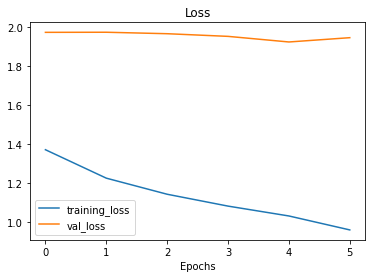

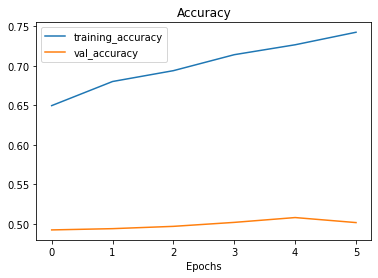

In [17]:
plot_loss_curves(history_1)

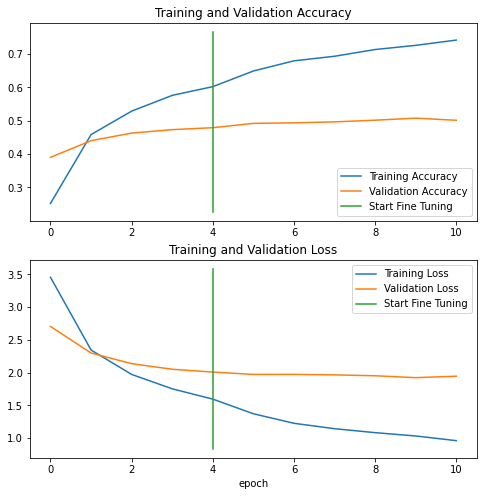

In [18]:
compare_historys(original_history=history_0,
                 new_history=history_1)

## Saved, Load and Evaluate the model

In [30]:
# Save our fine-tuning model
model_0.save("/content/drive/MyDrive")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/assets


In [20]:
loaded_model = tf.keras.models.load_model("drive/MyDrive/101_food_classes_10_percent")

In [21]:
loaded_model_evaluate = loaded_model.evaluate(validate_data)
print(loaded_model_evaluate)

790/790 [==============================] - 60s 74ms/step - loss: 1.6199 - accuracy: 0.5714
[1.619911551475525, 0.5714455246925354]


In [22]:
print(evaluate_0)

[1.7243707180023193, 0.5479999780654907]


Evaluating the performance of the big model across all diffrent classes

In [23]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2022-06-15 11:38:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   189MB/s    in 0.2s    

2022-06-15 11:38:35 (189 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [24]:
unzip_data('/content/06_101_food_class_10_percent_saved_big_dog_model.zip')

In [28]:
model = tf.keras.models.load_model('/content/06_101_food_class_10_percent_saved_big_dog_model')

In [31]:
loaded_model_evaluate = model.evaluate(validate_data)

790/790 [==============================] - 61s 75ms/step - loss: 1.8027 - accuracy: 0.6078


## Making predictions with our trained model

In [33]:
# Make predictions with model
preds_probs = model_0.predict(validate_data,verbose=1)

790/790 [==============================] - 62s 76ms/step


In [34]:
preds_probs.shape

(25250, 101)

In [36]:
# Let's see what the first 10 predictions look like
preds_probs[0:10]

array([[2.4575886e-01, 3.7213813e-05, 3.0826283e-01, ..., 5.2192197e-05,
        3.8981432e-04, 7.8968890e-02],
       [9.5374751e-01, 2.0301341e-07, 1.6552637e-03, ..., 9.0446061e-04,
        3.9024989e-08, 1.2652160e-06],
       [2.1656995e-01, 5.8219563e-03, 1.8320272e-02, ..., 6.9104246e-04,
        1.2810734e-03, 3.5234950e-03],
       ...,
       [3.8130841e-01, 1.5610944e-05, 2.2312957e-03, ..., 2.6881447e-02,
        1.6857586e-04, 2.3014421e-04],
       [1.1808429e-01, 5.7992892e-04, 1.0138501e-01, ..., 3.8359742e-04,
        7.0921349e-05, 4.2610269e-04],
       [5.0368315e-01, 1.6492781e-06, 9.4464235e-04, ..., 9.7099766e-03,
        3.3601759e-06, 1.1960715e-03]], dtype=float32)

In [41]:
print(f"{preds_probs[0]}, \n Length of the model: {len(preds_probs[0])}")

[2.45758861e-01 3.72138129e-05 3.08262825e-01 8.15317946e-09
 9.07125695e-07 1.15552291e-06 1.07959364e-04 2.64229038e-06
 2.42198519e-02 3.88919027e-04 1.39154236e-06 4.45779642e-06
 1.13831647e-03 2.07094459e-07 7.55164865e-03 4.10827342e-04
 4.09174572e-06 6.96799834e-04 4.10112960e-04 1.36604024e-06
 1.05675965e-04 2.41706130e-05 1.63529476e-04 2.60404136e-04
 5.52605663e-04 4.30255255e-04 2.61021720e-04 5.32333725e-05
 1.79072395e-01 4.29656997e-04 4.90632431e-07 5.76121965e-04
 4.40787466e-04 8.11737877e-08 2.08602729e-03 1.20598688e-05
 4.94104315e-05 2.35826534e-04 1.34046320e-02 1.62646920e-05
 1.51073124e-04 1.66841608e-03 4.85846133e-04 1.69030000e-06
 5.72585623e-06 8.71261454e-06 3.98195873e-04 1.72260479e-04
 2.96082703e-07 5.13609089e-02 4.35819617e-04 2.04979824e-05
 1.76576544e-02 3.83613259e-03 1.00309326e-05 7.10053090e-03
 1.12102423e-02 8.41721892e-04 5.81809133e-03 3.38007449e-05
 9.95917958e-07 1.96175315e-04 1.20831570e-02 1.02636339e-04
 4.96551256e-05 2.212102

In [43]:
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like: \n {preds_probs[0]}")
print(f" The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like: 
 [2.45758861e-01 3.72138129e-05 3.08262825e-01 8.15317946e-09
 9.07125695e-07 1.15552291e-06 1.07959364e-04 2.64229038e-06
 2.42198519e-02 3.88919027e-04 1.39154236e-06 4.45779642e-06
 1.13831647e-03 2.07094459e-07 7.55164865e-03 4.10827342e-04
 4.09174572e-06 6.96799834e-04 4.10112960e-04 1.36604024e-06
 1.05675965e-04 2.41706130e-05 1.63529476e-04 2.60404136e-04
 5.52605663e-04 4.30255255e-04 2.61021720e-04 5.32333725e-05
 1.79072395e-01 4.29656997e-04 4.90632431e-07 5.76121965e-04
 4.40787466e-04 8.11737877e-08 2.08602729e-03 1.20598688e-05
 4.94104315e-05 2.35826534e-04 1.34046320e-02 1.62646920e-05
 1.51073124e-04 1.66841608e-03 4.85846133e-04 1.69030000e-06
 5.72585623e-06 8.71261454e-06 3.98195873e-04 1.72260479e-04
 2.96082703e-07 5.13609089e-02 4.35819617e-04 2.04979824e-05
 1.76576544e-02 3.83613259e-03 1.00309326e-05 7.10053090e-03
 1.12102423e-02 8.41721892e-04 5.81809133e

In [45]:
pred_classes = preds_probs.argmax(axis=1)

pred_classes[:10]

array([ 2,  0,  0,  8, 79, 78, 29,  0,  9,  0])

In [47]:
print('helloworld')

helloworld


In [54]:
y_labels = []
for images,labels in validate_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [50]:
print(type(validate_data))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


In [49]:
len(validate_data)

790

## Evaluating our model's predictions

In [55]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true=y_labels,
                          y_pred=pred_classes)

print(accuracy)

0.5714455445544554


In [57]:
loaded_model_evaluate

[1.8027206659317017, 0.6077623963356018]